# 10X Genomics 1.3 Million Cells Tutorial

This code will guide you through loading the [1.3 Million Brain Cells from E18 Mice](https://support.10xgenomics.com/single-cell/datasets/1M_neurons) produced by 10X Genomics.

Note that this requires at least __32GB of RAM__.

This requires the following Python packages: Matplotlib, NumPy, SciPy, Pandas, PyTables. 
The easiest way to obtain these packages (as well as Jupyter Notebook) is to install [Anaconda](https://www.continuum.io/downloads).

In [4]:
# import modules, define some functions for loading, saving and processing a gene-barcode matrix
%matplotlib inline
import collections
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp_sparse
import tables

np.random.seed(0)

GeneBCMatrix = collections.namedtuple('GeneBCMatrix', ['gene_ids', 'gene_names', 'barcodes', 'matrix'])

def get_matrix_from_h5(filename, genome):
    with tables.open_file(filename, 'r') as f:
        try:
            dsets = {}
            for node in f.walk_nodes('/' + genome, 'Array'):
                dsets[node.name] = node.read()
            matrix = sp_sparse.csc_matrix((dsets['data'], dsets['indices'], dsets['indptr']), shape=dsets['shape'])
            return GeneBCMatrix(dsets['genes'], dsets['gene_names'], dsets['barcodes'], matrix)
        except tables.NoSuchNodeError:
            raise Exception("Genome %s does not exist in this file." % genome)
        except KeyError:
            raise Exception("File is missing one or more required datasets.")

def save_matrix_to_h5(gbm, filename, genome):
    flt = tables.Filters(complevel=1)
    with tables.open_file(filename, 'w', filters=flt) as f:
        try:
            group = f.create_group(f.root, genome)
            f.create_carray(group, 'genes', obj=gbm.gene_ids)
            f.create_carray(group, 'gene_names', obj=gbm.gene_names)
            f.create_carray(group, 'barcodes', obj=gbm.barcodes)
            f.create_carray(group, 'data', obj=gbm.matrix.data)
            f.create_carray(group, 'indices', obj=gbm.matrix.indices)
            f.create_carray(group, 'indptr', obj=gbm.matrix.indptr)
            f.create_carray(group, 'shape', obj=gbm.matrix.shape)
        except:
            raise Exception("Failed to write H5 file.")
        
def subsample_matrix(gbm, barcode_indices):
    return GeneBCMatrix(gbm.gene_ids, gbm.gene_names, gbm.barcodes[barcode_indices], gbm.matrix[:, barcode_indices])

def get_expression(gbm, gene_name):
    gene_indices = np.where(gbm.gene_names == gene_name)[0]
    if len(gene_indices) == 0:
        raise Exception("%s was not found in list of gene names." % gene_name)
    return gbm.matrix[gene_indices[0], :].toarray().squeeze()

In [1]:
# download data
# run this cell to download data (NOTE: requires 5GB of space in the current directory)
# alternatively, copy these to the command line (omitting the initial '!' character)
!wget --no-check-certificate https://s3-us-west-2.amazonaws.com/10x.files/samples/cell/1M_neurons/1M_neurons_filtered_gene_bc_matrices_h5.h5
!wget --no-check-certificate https://s3-us-west-2.amazonaws.com/10x.files/samples/cell/1M_neurons/1M_neurons_web_summary.html
!wget --no-check-certificate https://s3-us-west-2.amazonaws.com/10x.files/samples/cell/1M_neurons/1M_neurons_reanalyze.csv
!wget --no-check-certificate https://s3-us-west-2.amazonaws.com/10x.files/samples/cell/1M_neurons/1M_neurons_analysis.tar.gz
!wget --no-check-certificate https://s3-us-west-2.amazonaws.com/10x.files/samples/cell/1M_neurons/1M_neurons_neuron20k.h5

--2017-02-10 16:29:44--  https://s3-us-west-2.amazonaws.com/10x.files/samples/cell/1M_neurons/1M_neurons_filtered_gene_bc_matrices_h5.h5
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.144.68
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.144.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4216018749 (3.9G) [binary/octet-stream]
Saving to: `1M_neurons_filtered_gene_bc_matrices_h5.h5'

100%[====================================>] 4,216,018,749 53.5M/s   in 78s     

2017-02-10 16:31:03 (51.2 MB/s) - `1M_neurons_filtered_gene_bc_matrices_h5.h5' saved [4216018749/4216018749]

--2017-02-10 16:31:03--  https://s3-us-west-2.amazonaws.com/10x.files/samples/cell/1M_neurons/1M_neurons_web_summary.html
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 54.231.185.32
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|54.231.185.32|:443... connected.
HTTP request sent, awaitin

In [3]:
# untar the secondary analysis
!tar -xzf 1M_neurons_analysis.tar.gz

In [5]:
# load matrix (NOTE: takes several minutes, requires 32GB of RAM)
filtered_matrix_h5 = "1M_neurons_filtered_gene_bc_matrices_h5.h5"
genome = "mm10"
%time gene_bc_matrix = get_matrix_from_h5(filtered_matrix_h5, genome)

CPU times: user 1min 51s, sys: 23.8 s, total: 2min 14s
Wall time: 3min 26s


In [6]:
# load TSNE and graph clustering
tsne = pd.read_csv("analysis/tsne/2_components/projection.csv")
clusters = pd.read_csv("analysis/clustering/graphclust/clusters.csv")

In [7]:
# subsample to 20k barcodes for easier analysis (feel free to change the number)
subsample_bcs = 20e3
subset = np.sort(np.random.choice(gene_bc_matrix.barcodes.size, size=subsample_bcs, replace=False))
subsampled_matrix = subsample_matrix(gene_bc_matrix, subset)
subsampled_tsne = tsne.loc[subset, :]
subsampled_clusters = clusters.loc[subset, :]

In [8]:
# calculate UMIs and genes per cell
umis_per_cell = np.asarray(subsampled_matrix.matrix.sum(axis=0)).squeeze()
genes_per_cell = np.asarray((subsampled_matrix.matrix > 0).sum(axis=0)).squeeze()

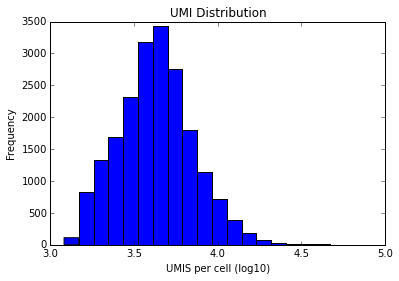

In [9]:
# plot UMIs per cell
plt.hist(np.log10(umis_per_cell), bins=20)
plt.xlabel('UMIS per cell (log10)')
plt.ylabel('Frequency')
plt.title('UMI Distribution')
plt.show()

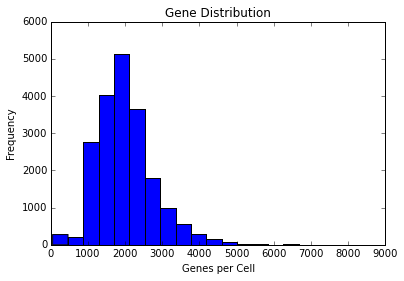

In [10]:
# plot genes per cell
plt.hist(genes_per_cell, bins=20)
plt.xlabel('Genes per Cell')
plt.ylabel('Frequency')
plt.title('Gene Distribution')
plt.show()

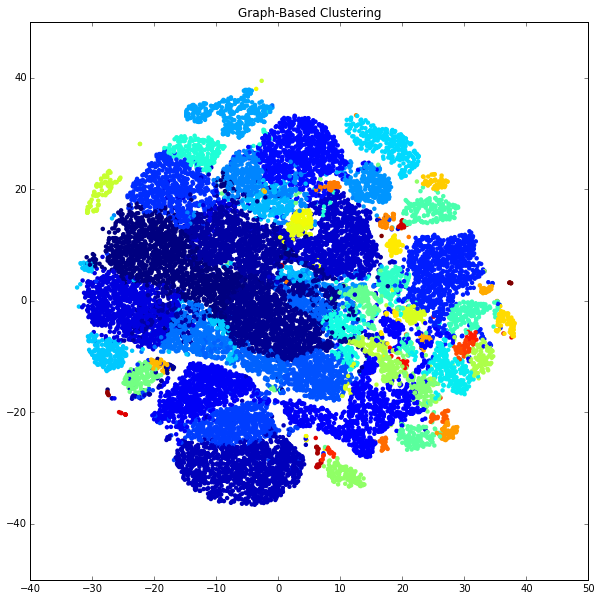

In [12]:
# plot clusters in TSNE space
plt.figure(figsize=(10, 10))
plt.scatter(subsampled_tsne['TSNE-1'], subsampled_tsne['TSNE-2'], c=subsampled_clusters['Cluster'], linewidths=0)
plt.title('Graph-Based Clustering')
plt.show()

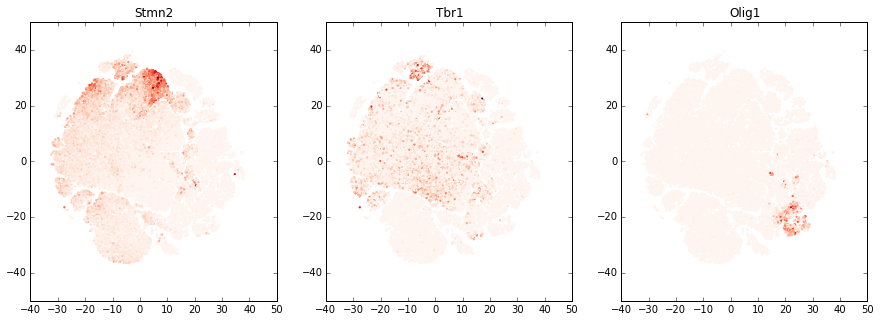

In [13]:
# plot three markers: Stmn2 (pan-neuronal), Tbr1 (excitatory), Olig1 (oligodendrocytes)
marker_genes = ['Stmn2', 'Tbr1', 'Olig1']
f, axes = plt.subplots(1, len(marker_genes), figsize=(5*len(marker_genes), 5))
for gene, axis in zip(marker_genes, axes):
    expr = get_expression(subsampled_matrix, gene)
    axis.scatter(subsampled_tsne['TSNE-1'], subsampled_tsne['TSNE-2'], c=expr, s=5, linewidths=0, cmap=plt.cm.Reds)
    axis.set_title(gene)
plt.show()

In [15]:
# write subsampled data for future reference
save_matrix_to_h5(subsampled_matrix, "1M_neurons_matrix_subsampled_20k.h5", "mm10")
subsampled_tsne.to_csv("1M_neurons_tsne_subsampled_20k.csv", index=False)
subsampled_clusters.to_csv("1M_neurons_graphclust_subsampled_20k.csv", index=False)